In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


## Data prep

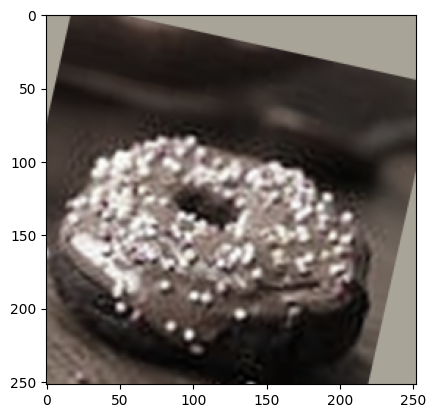

In [61]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import PIL
from PIL import Image

# random example images
selected_filename = "all_imgs/0a25adb3-a974-4276-96fc-7ecb99de606c.jpeg"
        
image = PIL.Image.open(selected_filename).convert('RGB').resize((252, 252), resample=Image.LANCZOS)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.85, 1.15), "y": (0.85, 1.15)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-25, 25), # rotate by -45 to +45 degrees
            shear=(-10, 10), # shear by -16 to +16 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 1),
            [
                #sometimes(iaa.Superpixels(p_replace=(0, 0.2), n_segments=(10, 50))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 1.5)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 5)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.25)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.BlendAlphaSimplexNoise(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.2, 0.5)),
                    iaa.DirectedEdgeDetect(alpha=(0.2, 0.5), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.3), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                #iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-5, 5), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-5, 5)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.8, 1.2), per_channel=0.5),
                    iaa.BlendAlphaFrequencyNoise(
                        exponent=(-4, 0),
                        foreground=iaa.Multiply((0.75, 1.25), per_channel=True),
                        background=iaa.LinearContrast((0.75, 1.25))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)
image_aug = seq(image=np.array(image))

plt.imshow(image_aug)
plt.show()

In [50]:
import os
import PIL
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image


class FoodData(Dataset):
    def __init__(self, setname):
        self.selected_dataset_dir = os.getcwd()
        self.setname = setname
        
        df = pd.read_csv('train.csv' ,header=0, index_col=0)
        self.num_classes = df['label'].max(0) + 1
        sep = int(len(df) * 0.9)

        if setname == 'train':
            self.all_filenames = list(df['path_img'])#[: sep]
            self.all_labels = df.set_index('path_img')#[: sep]
        
        if setname == 'test':
            self.all_filenames = list(df['path_img'][sep :])
            self.all_labels = df.set_index('path_img')[sep :]

        if setname == 'f':
            df = pd.read_csv('test.csv' ,header=0, index_col=0)
            self.all_filenames = list(df['path_img'])


    def __len__(self):
        return len(self.all_filenames)
        

    def __getitem__(self, idx):
        selected_filename = self.all_filenames[idx]
        
        # avg size: 255 219
        imagepil = PIL.Image.open(os.path.join(self.selected_dataset_dir,selected_filename)).convert('RGB').resize((252, 252), resample=Image.LANCZOS)

        if self.setname == 'train': 
            image_aug = np.array(seq(image=np.array(imagepil)))
        else: image_aug = imagepil

        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        image = transform(image_aug)

        if self.setname == 'train' or self.setname == 'test':
            label = torch.nn.functional.one_hot(torch.tensor(self.all_labels.loc[selected_filename]), self.num_classes).float()
        else: label = -1
        
        sample = {'data':image, #image, for input into NN
                  'label':label}

        return image, label

In [62]:
batch_size = 62

trainset = FoodData('train')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=12)

testset = FoodData('test')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=12)

classes = ('burger', 'chicken', 'doughnut', 'chips',
           'hot-dog', 'pizza', 'sandwich', 'potato')

([<matplotlib.patches.Wedge at 0x7f2ad10f1ba0>,
 [Text(1.0219335085947012, 0.4070035675658432, 'burger'),
  Text(0.43411186761813836, 1.010716026583675, 'chicken'),
  Text(-0.4482564698933137, 1.004522840556045, 'doughnut'),
  Text(-1.045107407469903, 0.3431479372683721, 'chips'),
  Text(-0.9770749922614587, -0.5052964075641847, 'hot-dog'),
  Text(-0.38539693419794724, -1.0302762751373165, 'pizza'),
  Text(0.41130347933333405, -1.0202104919516823, 'sandwich'),
  Text(1.0125351871389145, -0.4298517125772139, 'potato')])

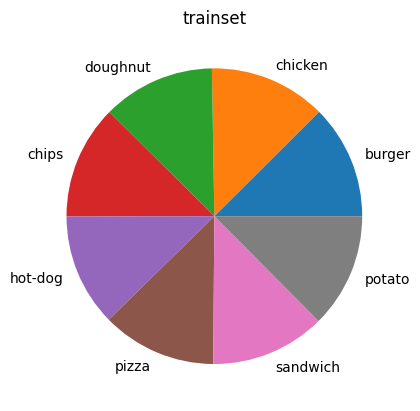

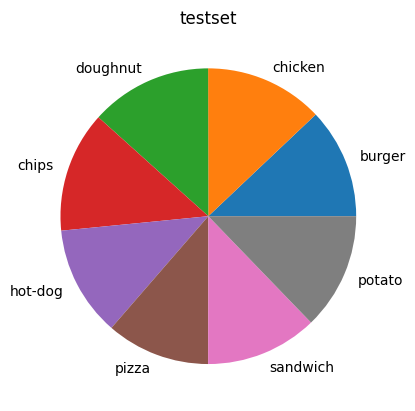

In [47]:
freq_train = [trainset.all_labels['label'].value_counts()[i] for i in range(trainset.num_classes)]
freq_test = [testset.all_labels['label'].value_counts()[i] for i in range(testset.num_classes)]

fig, ax = plt.subplots()
plt.title('trainset')
ax.pie(freq_train, labels=classes)

fig, ax = plt.subplots()
plt.title('testset')
ax.pie(freq_test, labels=classes)

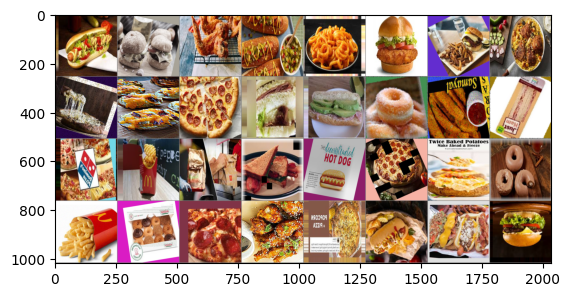

hot-dog burger chicken hot-dog chips chicken burger chicken pizza potato pizza sandwich sandwich doughnut chips sandwich pizza chips burger sandwich hot-dog pizza potato doughnut chips doughnut pizza chicken pizza hot-dog hot-dog burger


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[torch.argmax(labels[j])]:5s}' for j in range(batch_size)))

## Net

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(2, 2) # 124
        self.drop = nn.Dropout(0.1)

        self.conv1 = nn.Conv2d(3, 6, 5) # 250
        torch.nn.init.xavier_uniform_(self.conv1.weight, 0.5)

        self.conv2 = nn.Conv2d(6, 15, 5) # 248
        torch.nn.init.xavier_uniform_(self.conv2.weight, 0.5)

        self.conv3 = nn.Conv2d(15, 38, 5) # 248
        torch.nn.init.xavier_uniform_(self.conv2.weight, 0.5)

        self.conv4 = nn.Conv2d(38, 88, 5) # 248
        torch.nn.init.xavier_uniform_(self.conv2.weight, 0.5)

        self.conv5 = nn.Conv2d(88, 188, 5) # 248
        torch.nn.init.xavier_uniform_(self.conv2.weight, 0.5)

        self.fc1 = nn.Linear(188 * 4 * 4, 300)
        torch.nn.init.xavier_normal_(self.fc1.weight, 0.5)

        self.fc12 = nn.Linear(300, 150)
        torch.nn.init.xavier_normal_(self.fc1.weight, 0.5)

        self.fc2 = nn.Linear(150, 50)
        torch.nn.init.xavier_normal_(self.fc2.weight, 0.5)

        self.fc3 = nn.Linear(50, 8)
        torch.nn.init.xavier_normal_(self.fc3.weight, 0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x))) 
        x = self.pool(F.leaky_relu(self.conv2(x))) 
        x = self.pool(F.leaky_relu(self.conv3(x))) 
        x = self.pool(F.leaky_relu(self.conv4(x))) 
        x = self.pool(F.leaky_relu(self.conv5(x))) 
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop(F.leaky_relu(self.fc1(x)))
        x = self.drop(F.leaky_relu(self.fc12(x)))
        x = self.drop(F.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)
print(net)
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.1, inplace=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 15, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(15, 38, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(38, 88, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(88, 188, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3008, out_features=300, bias=True)
  (fc12): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=8, bias=True)
)
1470293


## Load and Save

In [9]:
# load
net = Net()
PATH = './version5conv5lin188.pth'
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.1, inplace=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 15, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(15, 38, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(38, 88, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(88, 188, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3008, out_features=300, bias=True)
  (fc12): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=8, bias=True)
)

In [32]:
# save
PATH = './version5conv5lin188.pth' 
torch.save(net.state_dict(), PATH)

## Train

In [41]:
def Accuracy():
    net.eval()
    with torch.no_grad():   
        correct, total = 0, 0
        for data in testloader:
            inputs, labels = data[0].to(device), torch.flatten(data[1], 1).to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            correct += (predicted == torch.argmax(labels, 1)).sum().item()
        return 100 * correct / total

In [63]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.00001, weight_decay=0.0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [64]:
losses = []
accu = []

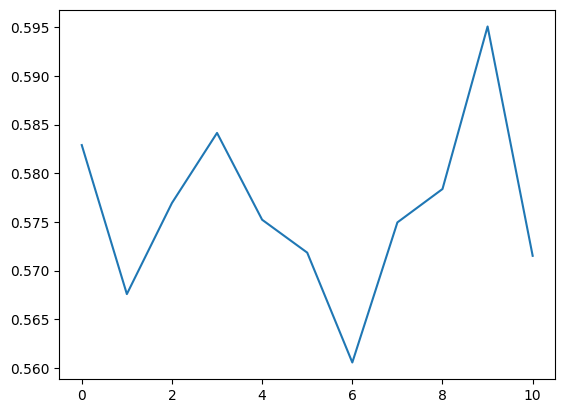

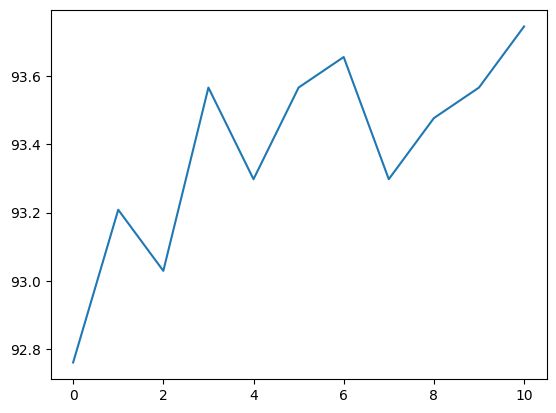

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

In [65]:
from matplotlib import pyplot as plt
from IPython.display import clear_output


for epoch in range(100):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), torch.flatten(data[1], 1).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if i % 100 == 0:    # print every 200 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
    scheduler.step()
    losses.append(running_loss / 100)
    accu.append(Accuracy())
    clear_output(wait = True)
    plt.plot(range(len(losses)), losses)
    plt.show()
    plt.plot(range(len(accu)), accu)
    plt.show()

print('Finished Training')

## Eval

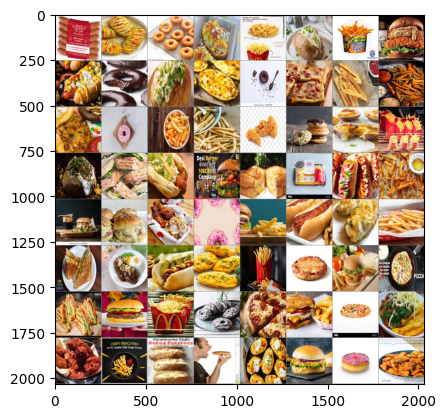

GroundTruth:  hot dog potato doughnut potato chips potato chips burger hot dog doughnut potato potato doughnut pizza chips chips doughnut doughnut chips chips chicken doughnut potato chips potato sandwich hot dog burger sandwich chips hot dog chips burger sandwich chicken doughnut chips hot dog potato chips sandwich burger hot dog potato chips pizza burger pizza sandwich burger chips doughnut pizza burger pizza chips chicken chips potato doughnut potato burger doughnut chicken
Predicted:  chips sandwich doughnut potato chips potato chicken chicken hot dog doughnut potato potato doughnut pizza chips chips chicken doughnut chips chips chicken burger potato pizza potato sandwich hot dog burger sandwich chips hot dog chips burger chicken chicken doughnut chips hot dog potato chips potato potato hot dog potato chips pizza burger hot dog sandwich burger chips chicken potato burger potato chicken chicken chips potato doughnut potato burger doughnut chicken


In [78]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[torch.argmax(labels[j])]:5s}' for j in range(batch_size)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}'
                              for j in range(batch_size)))

In [11]:
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    correct, total = 0, 0
    for data in trainloader:
        inputs, labels = data[0].to(device), torch.flatten(data[1], 1).to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)

        correct += (predicted == torch.argmax(labels, 1)).sum().item()

    print(f'Accuracy of the network on the 90% train images: {100 * correct / total} %')
        
    correct, total = 0, 0
    for data in testloader:
        inputs, labels = data[0].to(device), torch.flatten(data[1], 1).to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)

        correct += (predicted == torch.argmax(labels, 1)).sum().item()

    print(f'Accuracy of the network on the 10% test images: {100 * correct / total} %')

MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_16.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy of the network on the 90% train images: 90.83416087388282 %
Accuracy of the network on the 10% test images: 78.37354781054513 %


In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            label = torch.argmax(label, 1)
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: burger is 80.0 %
Accuracy for class: chicken is 80.0 %
Accuracy for class: doughnut is 83.2 %
Accuracy for class: chips is 79.1 %
Accuracy for class: hot-dog is 73.3 %
Accuracy for class: pizza is 80.3 %
Accuracy for class: sandwich is 71.5 %
Accuracy for class: potato is 79.0 %


## Entrega

In [66]:
fset = FoodData('f')
floader = torch.utils.data.DataLoader(fset, batch_size=1,
                                         shuffle=False, num_workers=12)

preds = {}
net.eval()
with torch.no_grad(): 
    for i, data in enumerate(floader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].to(device)

        # forward + backward + optimize
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        preds[i] = predicted.item()

preds = {'target': preds}
print(preds)

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


{'target': {0: 2, 1: 2, 2: 6, 3: 6, 4: 5, 5: 5, 6: 7, 7: 4, 8: 6, 9: 0, 10: 0, 11: 5, 12: 5, 13: 7, 14: 2, 15: 6, 16: 2, 17: 5, 18: 1, 19: 6, 20: 3, 21: 2, 22: 7, 23: 0, 24: 1, 25: 3, 26: 5, 27: 4, 28: 0, 29: 4, 30: 4, 31: 3, 32: 4, 33: 5, 34: 4, 35: 6, 36: 3, 37: 7, 38: 3, 39: 0, 40: 4, 41: 7, 42: 7, 43: 5, 44: 5, 45: 7, 46: 0, 47: 3, 48: 6, 49: 4, 50: 4, 51: 5, 52: 0, 53: 0, 54: 0, 55: 7, 56: 3, 57: 1, 58: 6, 59: 6, 60: 5, 61: 4, 62: 7, 63: 6, 64: 7, 65: 2, 66: 4, 67: 6, 68: 4, 69: 1, 70: 4, 71: 4, 72: 7, 73: 3, 74: 1, 75: 7, 76: 2, 77: 7, 78: 3, 79: 5, 80: 7, 81: 3, 82: 1, 83: 0, 84: 7, 85: 2, 86: 4, 87: 3, 88: 1, 89: 1, 90: 5, 91: 2, 92: 0, 93: 4, 94: 0, 95: 0, 96: 1, 97: 2, 98: 7, 99: 7, 100: 3, 101: 6, 102: 5, 103: 0, 104: 4, 105: 3, 106: 2, 107: 5, 108: 0, 109: 0, 110: 7, 111: 1, 112: 3, 113: 7, 114: 5, 115: 6, 116: 3, 117: 7, 118: 1, 119: 7, 120: 6, 121: 7, 122: 1, 123: 1, 124: 5, 125: 3, 126: 1, 127: 3, 128: 4, 129: 6, 130: 5, 131: 6, 132: 5, 133: 4, 134: 5, 135: 4, 136: 6, 13

In [67]:
import json

with open("results3.json", "w") as out:
    jsonStr = json.dump(preds, out)